### 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

### 전체 그래프 state

In [3]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)

# LLM 초기화
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

In [4]:
from pydantic import BaseModel, Field

class MusicResponse(BaseModel):
    """
    에이전트가 반환할 음악 추천 데이터를 구조화하기 위한 모델입니다.

    Attributes:
        title (str): 추천된 곡 제목.
        artist (str): 곡 아티스트 이름.
        url (str): Spotify 트랙 URL.
        reason (str): 추천 이유.
    """
    title: str = Field(..., description="추천된 곡 제목")
    artist: str = Field(..., description="곡 아티스트 이름")
    url: str = Field(..., description="Spotify 트랙 URL")
    reason: str = Field(..., description="추천 이유")

In [5]:
from pydantic import BaseModel, Field

# ---------------------------------------------------
# Pydantic 모델: 에이전트 구조화된 출력을 위한 스키마 정의
# ---------------------------------------------------
class QuoteResponse(BaseModel):
    """
    에이전트가 반환할 명언 데이터를 구조화하기 위한 모델입니다.

    Attributes:
        quote (str): 추천된 명언 텍스트.
        author (str): 명언을 남긴 사람의 이름 (출처).
        explanation (str): 왜 이 명언이 해당 일기 상황에 적절한지 설명하는 따뜻한 메시지.
    """
    quote: str = Field(..., description="추천 명언")
    author: str = Field(..., description="명언 출처(말한 사람)")
    explanation: str = Field(..., description="왜 이 명언이 적절한지에 대한 설명")

In [6]:
from typing import TypedDict

class SecretFriendState(TypedDict):
    diary_body: str
    praise: str
    music: MusicResponse
    quote: QuoteResponse
    F_feedback: str
    T_feedback: str
    letter_markdown: str

### 음악 추천 Agent

In [7]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify API 인증 설정
sp = spotipy.Spotify(
    client_credentials_manager=SpotifyClientCredentials(
        client_id=os.getenv("SPOTIFY_CLIENT_ID"), client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")
    )
)

In [8]:
from typing import Type
from pydantic import BaseModel, Field
from langchain.tools import BaseTool
from langchain import PromptTemplate
import random

class SpotifyToolInput(BaseModel):
    diary: str = Field(
        ..., description="일기 본문 텍스트를 입력합니다."
    )
    keyword: str = Field(
        ..., description="일기에서 추출한 핵심 키워드"
    )

class SpotifyTool(BaseTool):
    """
    Spotify Music Recommender
    - Input: diary를 args_schema로 직접 받음
    - Output: 일기에서 추출한 키워드를 기반으로 Spotify 검색 API 사용해 단 하나의 곡 추천
    """
    name: str = "spotify_recommender_tool"
    description: str = (
        "일기 본문을 받아, 일기에서 주요 키워드를 추출한 뒤,"
        "Spotify 검색 API를 활용해 단 하나의 곡을 추천합니다."
    )
    args_schema: Type[BaseModel] = SpotifyToolInput
    
    def _run(self, diary: str, keyword: str) -> str:
        # 입력 검증
        diary_body = diary.strip()
        if not diary_body:
            return "일기 본문을 입력해주세요."
        
        keyword = keyword.strip()
        if not keyword:
            return "keyword를 다시 생성해 입력해주세요."

        # 곡 추천
        query = f"{keyword}"
        offset = random.randint(0, 50)  # 오프셋을 랜덤으로 설정하여 다양한 곡 추천
        results = sp.search(q=query, type="track", limit=1, offset=offset, market="KR")
        items = results.get("tracks", {}).get("items", [])
        if items:
            track = items[0]
            title = track.get("name")
            artist_name = track.get("artists", [{}])[0].get("name")
            url = track.get("external_urls", {}).get("spotify")
            return f"""제목은 [{title}], 가수는 [{artist_name}], url은 [{url}] 입니다."""

        return f"'{keyword}' 키워드에 맞는 추천 곡을 찾지 못했습니다."

    def _arun(self):
        raise NotImplementedError("Spotify Music Recommender does not support ")


In [9]:
from langchain_core.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate

music_parser = PydanticOutputParser(pydantic_object=MusicResponse)
music_chat_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "너는 사용자의 일기를 읽고 어울리는 음악을 추천하는 비밀 친구야.\n"
        "\n"
        "너의 역할은 다음과 같아:\n"
        "1. 사용자의 일기 내용을 읽고, 긍정적이거나 따뜻한 느낌의 **핵심 키워드** 하나를 추출해.\n"
        "   - 키워드는 한 단어로, 명사 형태로 작성해야 해.\n"
        "   - 일기 분위기가 우울하면 '위로', '평화' 같은 키워드를 사용해도 좋아.\n"
        "\n"
        "2. 그 키워드를 사용해 반드시 `spotify_recommender_tool`을 호출해서 음악을 검색해.\n"
        "   - Tool의 입력은 다음과 같아:\n"
        "     - diary: 일기 전체 본문\n"
        "     - keyword: 너가 추출한 키워드 (한 단어)\n"
        "\n"
        "3. 만약 곡을 찾지 못했다면 사용자의 일기 내용을 읽고, 다른 키워드로 바꿔서 **Tool을 다시 호출**해.'\n"
        "   - 같은 키워드를 반복 호출하지 말고 반드시 **다른 키워드**를 새로 생성해서 다시 시도해.\n"
        "   - 최종적으로 반드시 적어도 1개의 곡을 찾아야 해.\n"
        "\n"
        "🎧 음악을 찾은 후에는 아래 JSON 형식으로만 응답해:\n"
        "{format_instructions}\n"
        "\n"
        "📝 'reason'은 친구가 해주는 듯한 따뜻한 반말로, 공감하며 작성해줘.\n"
        "그 외 문장이나 설명은 출력하지 마."
    ),
    ("placeholder", "{chat_history}"),
    ("human", "# 일기 내용 : {input}"),
    ("placeholder", "{agent_scratchpad}")
])

music_chat_prompt = music_chat_prompt.partial(
    format_instructions=music_parser.get_format_instructions()
)

In [13]:
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

music_tools = [SpotifyTool()]

music_agent = create_tool_calling_agent(
    llm=llm,
    tools=music_tools,
    prompt=music_chat_prompt
)

# AgentExecutor 생성
music_agent_executor = AgentExecutor(agent=music_agent, tools=music_tools, verbose=True)

In [14]:
def music_recommendation_node(state: SecretFriendState) -> SecretFriendState:
    """
    SecretFriendState에서 diary_body 읽어 음악 추천을 수행하고,
    MusicResponse로 파싱한 뒤 state['music']에 저장합니다.
    """
    # 1) 에이전트 호출: '일기본문||아티스트1,아티스트2,...' 형태 입력
    raw = music_agent_executor.invoke({"input": state['diary_body']})
    
    # 2) 추천 결과 파싱
    # music_parser는 MusicResponse용 PydanticOutputParser로 정의되어야 합니다.
    music_resp = music_parser.parse(raw['output'])
    
    # 3) 상태에 저장
    return SecretFriendState(
        music=music_resp,
    )

### 명언 추천 Agent

In [15]:
from langchain_tavily import TavilySearch

# TavilySearchResults 기반 명언 추천 도구
tavily_tool = TavilySearch(
    max_results=3,             # 최대 답변 수
    include_answer=True,       # 원본 쿼리에 대한 짧은 답변 포함
    include_raw_content=True   # HTML 원본 내용 포함
)

# 도구 이름 및 설명 설정
tavily_tool.description = (
    "일기 내용을 기반으로 사용자를 위로하거나 격려할 수 있는 명언을 검색합니다. "
    "사용자가 제공한 일기 텍스트에 적합한 명언과 간단한 해설을 최대 3건 반환합니다."
)

In [16]:

from langchain_core.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate

quote_parser = PydanticOutputParser(pydantic_object=QuoteResponse)

quote_chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", 
        "너는 사용자의 일기를 읽고 위로가 될 만한 명언을 하나 추천하는 따뜻한 친구야.\n"
        "명언은 반드시 출처(말한 사람)를 포함해야 하고, 'Unknown'이나 출처 불분명한 명언은 절대 추천하지 마.\n"
        "검색할 땐 반드시 '명언' 또는 'quote'가 포함된 쿼리로 검색해야 해. 예: '사랑 명언', '성장 quote'\n"
        "검색에는 tavily_search_results_json 도구를 사용해야 해.\n"
        "왜 이 명언이 어울리는지에 대한 이유는 친구처럼 다정한 반말로, 따뜻하게 설명해줘.\n"
        "결과는 반드시 아래 JSON 형식 가이드에 따라 구조화해야 해.\n"
        "{format_instructions}"),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ]
)
quote_chat_prompt = quote_chat_prompt.partial(format_instructions=quote_parser.get_format_instructions())

In [17]:
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

quote_tools = [tavily_tool]

quote_agent = create_tool_calling_agent(
    llm=llm,
    tools=quote_tools,
    prompt=quote_chat_prompt
)

# AgentExecutor 생성
quote_agent_executor = AgentExecutor(agent=quote_agent, tools=quote_tools, verbose=True)


In [18]:
# 명언 추천 노드 정의
def quote_recommendation_node(state: SecretFriendState) -> SecretFriendState:
    """
    SecretFriendState에서 diary_body를 읽어 명언을 검색하고,
    QuoteResponse로 파싱한 뒤 state['quote']에 저장합니다.
    """
    # 1) 일기 본문으로 에이전트 실행
    raw = quote_agent_executor.invoke({"input": state['diary_body']})
    # 2) output 파싱
    quote_resp = quote_parser.parse(raw['output'])
    
    # 3) 상태 업데이트
    return SecretFriendState(
        quote=quote_resp
    )

### 오늘의 칭찬 / T와 F의 피드백

In [19]:
praise_prompt = PromptTemplate(
    input_variables=["diary_body"],
    template=(
        "다음은 사용자가 작성한 오늘의 일기야. 이 글을 바탕으로 사용자가 얼마나 노력했고, 그 노력이 얼마나 소중한지 진짜 찐친처럼 따뜻하게 공감해 줘.\n\n"
        "✅ 아래 기준을 꼭 반영해서 '한 문장'의 칭찬 메시지를 찐친처럼 편하게 작성해줘:\n"
        "- 일기 속에서 한 가지 행동, 감정, 선택을 골라서 구체적으로 언급할 것\n"
        "- 반응형 표현 적극 활용. 사소한 것도 완전 크게 칭찬해줘\n"
        "- 찐친만이 할 수 있는 솔직하고 직설적이면서도 애정 어린 톤으로 작성할 것\n"
        "- 자존감 폭발하게 해줘 - 무근본이어도 됨!\n"
        "- 단, 범죄, 폭력, 자해, 우울, 혐오 등 부정적인 행동이나 사고에 대해서는 절대 미화하거나 긍정하지 말 것\n\n"
        "📝 일기: '''{diary_body}'''"
    )
)


F_feedback_prompt = PromptTemplate(
    input_variables=["diary_body"],
    template=(
        "너는 지금 MBTI에서 F(Function: Feeling) 유형의 사용자에게 감정적인 위로와 공감을 전하려고 해.\n"
        "F 유형은 타인의 감정에 민감하고, 조화로운 관계와 감정의 흐름을 중요하게 여겨. 이들은 따뜻한 말 한마디로 큰 위로를 받으며, 진심 어린 공감과 인정에 큰 가치를 둬.\n\n"
        "다음 일기를 읽고, 사용자의 감정에 부드럽게 공감하고 따뜻하게 감싸줄 수 있는 한 문단의 위로 메시지를 친구처럼 반말로 작성해줘.\n"
        "✅ 반드시 아래 기준을 지켜 줘:\n"
        "- 사용자의 감정을 존중하며, 고통이나 혼란 속에서도 잘 견뎌낸 점을 부각할 것\n"
        "- 따뜻하고 진심 어린 친구 같은 반말로 위로하며, 무조건적인 긍정보다는 현실적인 공감을 우선할 것\n"
        "- 폭력, 범죄, 자해, 우울감 등 부정적 사건이 포함된 경우, 이를 미화하지 말고 신중하게 공감의 태도로 접근할 것\n\n"
        "📝 사용자 일기: '''{diary_body}'''"
    )
)


T_feedback_prompt = PromptTemplate(
    input_variables=["diary_body"],
    template=(
        "너는 지금 MBTI에서 T(Function: Thinking) 유형의 사용자에게 논리적이고 실용적인 조언을 전달하려고 해.\n"
        "T 유형은 문제 해결 중심이며, 감정보다 사실과 효율을 중요시해. 이들은 진심 어린 피드백과 명확한 제안을 통해 스스로를 돌아보고 개선하려는 경향이 있어.\n\n"
        "다음 일기를 읽고, 사용자가 더 나은 선택을 할 수 있도록 건설적인 조언을 담은 한 문단의 메시지를 친구처럼 반말로 작성해줘.\n"
        "✅ 반드시 아래 기준을 지켜 줘:\n"
        "- 감정적인 언급은 최소화하되, 지나치게 차갑지 않도록 친근한 반말 톤으로 균형을 유지할 것\n"
        "- 사용자의 선택이나 행동 중 개선하거나 성장의 여지가 있는 부분을 정중하게 짚어줄 것\n"
        "- 부정적인 상황(예: 실패, 우울감 등)에 대해서는 현실적인 개선 방향이나 조치 방법을 친구처럼 제안할 것\n"
        "- 범죄, 자해, 혐오 등은 절대 정당화하지 않고, 책임감 있는 조언으로 유도할 것\n\n"
        "📝 사용자 일기: '''{diary_body}'''"
    )
)

In [20]:
# 칭찬 생성 노드
def praise_node(state: SecretFriendState) -> SecretFriendState:
    """
    사용자의 일기 본문을 읽고, 오늘의 노력을 반영한 따뜻한 칭찬 한 문장을 생성해
    state['praise']에 저장합니다.
    """
    diary = state['diary_body']
    # LLM invoke로 템플릿 실행
    response = llm.invoke([praise_prompt.format(diary_body=diary)])

    return SecretFriendState(
        praise=response.content.strip(),
    )

In [21]:
# MBTI 피드백 노드
def mbti_feedback_node(state: SecretFriendState) -> SecretFriendState:
    """
    사용자의 일기 본문을 읽고, F 유형에게 위로 메시지, T 유형에게 조언 메시지를 생성해
    state['F_feedback'], state['T_feedback']에 저장합니다.
    """
    diary = state['diary_body']
    # F 유형 위로
    f_resp = llm.invoke([F_feedback_prompt.format(diary_body=diary)])

    # T 유형 조언
    t_resp = llm.invoke([T_feedback_prompt.format(diary_body=diary)])

    return SecretFriendState(
        F_feedback=f_resp.content.strip(),
        T_feedback=t_resp.content.strip(),
    )

### 전체 그래프

In [22]:
def start_node_check(state: SecretFriendState) -> SecretFriendState:
    """
    SecretFriendState의 초기 상태를 확인하고,
    병렬 처리를 위해 diary_body를 각 노드용으로 복사합니다.
    """
    diary_body = state.get('diary_body', '').strip()
    
    if not diary_body:
        raise ValueError("일기 본문이 비어 있습니다. 일기를 작성해주세요.")

    return state

In [23]:
def letter_markdown(state: SecretFriendState) -> SecretFriendState: 
    """
    SecretFriendState의 내용을 마크다운 편지 형식으로 변환하여 letter_markdown 필드에 저장합니다.
    """
    # 구조 분해
    music = state['music']
    quote = state['quote']
    praise = state['praise']
    F_feedback = state['F_feedback']
    T_feedback = state['T_feedback']

    markdown_content = f"""# 💌 비밀친구의 편지

너를 위해 작지만 따뜻한 편지를 준비했어.

---

## 🌟 오늘의 칭찬

> {praise}

---

## 🎵 오늘의 음악 추천

**{music.title}** - *{music.artist}*  
🔗 [음악 들으러 가기]({music.url})  
_👉 {music.reason}_

---

## 📝 오늘의 명언

> “{quote.quote}”  
> — *{quote.author}*  
{quote.explanation}

---

## 🌷 F의 위로

{F_feedback}

---

## 🧭 T의 조언

{T_feedback}

---

비밀친구가 여기 있다는 걸 잊지 마.  
내일도 네 편이 되어줄게.

다 잘 될 거야! ☁️
잘 자.

— 너의 비밀친구가 -
"""

    return SecretFriendState(
        letter_markdown=markdown_content
    )


In [24]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
letter_workflow = StateGraph(SecretFriendState)

letter_workflow.add_node("start_node_check", start_node_check)
letter_workflow.add_edge(START, "start_node_check")
letter_workflow.add_node("music", music_recommendation_node)
letter_workflow.add_node("quote", quote_recommendation_node)
letter_workflow.add_node("praise", praise_node)
letter_workflow.add_node("mbti_feedback", mbti_feedback_node)
letter_workflow.add_node("letter_markdown", letter_markdown)


# 노드 연결
letter_workflow.add_edge("start_node_check", "music")
letter_workflow.add_edge("start_node_check", "quote")
letter_workflow.add_edge("start_node_check", "praise")
letter_workflow.add_edge("start_node_check", "mbti_feedback")
letter_workflow.add_edge("music", "letter_markdown")
letter_workflow.add_edge("quote", "letter_markdown")
letter_workflow.add_edge("praise", "letter_markdown")
letter_workflow.add_edge("mbti_feedback", "letter_markdown")
letter_workflow.add_edge("letter_markdown", END)


# 그래프 컴파일
letter_graph = letter_workflow.compile()

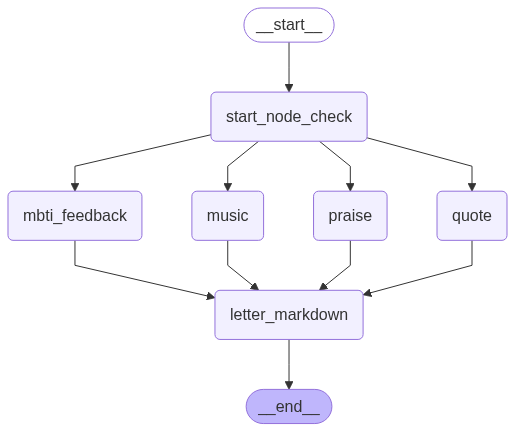

In [25]:
from IPython.display import Image, display

display(
        Image(letter_graph.get_graph(xray=True).draw_mermaid_png())
) 

In [26]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
test_state = {
    'diary_body': """오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.

오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.

저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.
    """
}

result = letter_graph.invoke(test_state)



> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `tavily_search` with `{'query': '성장 명언'}`


{'query': '성장 명언', 'follow_up_questions': None, 'answer': '성장은 도전을 통해 이루어지며, 지속적인 노력이 중요합니다. 성장은 끊임없는 변화와 발전의 과정입니다. 성장은 한계를 뛰어넘고 새로운 가능성을 발견하는 것입니다.', 'images': [], 'results': [{'url': 'https://heartpd.tistory.com/53', 'title': '도전과 성장을 이끄는 10가지 명언 모음 - 하트피리', 'content': "도전과 성장을 이끄는 10가지 명언 모음 도전과 성장을 이끄는 10가지 명언 모음 이 글을 통해 도전과 성장의 중요성을 알리고 여러분의 인생에 긍정적인 영향을 끼칠 수 있기를 바랍니다. 도전을 통해 우리는 더 큰 성취와 발전을 이루어낼 수 있습니다. 도전의 가치를 깨닫고, 더 큰 도약을 꿈꾸세요. 도전을 통해 더 큰 성장을 이룰 수 있습니다. 자신의 한계를 뛰어넘는 도전을 통해 인생의 가치를 찾아가세요. 도전의 가치를 인식하고 더 큰 가능성을 찾아가세요. 도전의 가치를 인식하고 자신에게 맞는 도전을 찾아 나아가세요. 이 글을 통해 여러분의 인생에 긍정적인 변화가 있기를 바라며, 도전의 가치를 높이 여기시길 바랍니다. #### '명언모음' 카테고리의 다른 글 *   '성장' 과 관련된 명언 모음: 인생을 변화시키는 명언들 2023.11.30 더보기 *   도전과 성장을 이끄는 10가지 명언 모음 | 내 블로그 - 관리자 홈 전환 | Q Q |", 'score': 0.6246834, 'raw_content': 'Published Time: 2023-04-19T16:29:40+09:00\n\n도전과 성장을 이끄는 10가지 명언 모음\n\n=====

In [27]:
from IPython.display import display, Markdown

display(Markdown(result['letter_markdown']))

# 💌 비밀친구의 편지

너를 위해 작지만 따뜻한 편지를 준비했어.

---

## 🌟 오늘의 칭찬

> 와, 너 오늘 아침에 6시에 일어나서 조깅한 거 진짜 대단한 거 알지? 아침 햇살 받으면서 상쾌하게 뛰었다니, 그거 완전 인생의 승리자야! 진짜 너의 그 부지런함과 자기 관리 능력, 나도 좀 나눠줘라! 🌟

---

## 🎵 오늘의 음악 추천

**Like the first snow** - *KIM JUNGHYUN*  
🔗 [음악 들으러 가기](https://open.spotify.com/track/2X3lOFzr9YOdzuGcug9F5o)  
_👉 첫눈을 보면서 느꼈던 그 포근한 기분을 이 노래가 잘 담고 있어. 마음이 따뜻해질 거야._

---

## 📝 오늘의 명언

> “도전 없이는 성취도 없다.”  
> — *Benjamin Franklin*  
오늘 하루는 정말 다양한 감정으로 가득했네! 아침 조깅의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함까지. 이런 하루를 보낸 너에게 이 명언이 딱 어울릴 것 같아. 벤자민 프랭클린이 말했듯이, 도전 없이는 성취도 없다고 해. 오늘 발표를 준비하면서 느꼈던 긴장감과 그걸 이겨내고 잘 해냈다는 성취감이 바로 그런 도전의 결과인 것 같아. 앞으로도 이런 도전들을 통해 더 많은 성취를 이뤄나가길 바랄게!

---

## 🌷 F의 위로

오늘 하루 정말 특별했겠다! 아침 조깅하면서 느낀 상쾌함과 뿌듯함, 그리고 프로젝트 발표의 긴장감 속에서도 잘 해낸 너의 모습이 정말 대단해. 그 순간순간을 잘 견뎌내고, 또 즐길 수 있는 너의 마음이 참 멋지다. 첫눈을 보면서 잠시 멈춰서 마음을 느낄 수 있었다니, 그 포근한 순간이 너에게 큰 위로가 되었을 것 같아. 발이 조금 아팠던 건 아쉽지만, 그럼에도 불구하고 하루를 잘 보내서 다행이야. 앞으로도 이런 소중한 순간들이 너에게 많이 찾아오길 바라. 언제나 너의 감정을 소중히 여기고, 그 안에서 힘을 얻는 너를 응원할게!

---

## 🧭 T의 조언

조깅하면서 느낀 상쾌함과 발표를 잘 마친 성취감, 그리고 첫눈의 포근함까지, 오늘 하루 정말 알차게 보냈네! 운동화가 발에 불편했다면, 조깅을 더 즐겁게 하기 위해서라도 새로운 운동화를 고려해보는 게 좋을 것 같아. 발이 편해야 더 오래, 더 자주 조깅할 수 있으니까. 그리고 발표 준비하면서 느낀 긴장감은 누구나 겪는 거지만, 네가 잘 해냈다는 점에서 자신감을 가져도 될 것 같아. 다음번에는 발표 전에 심호흡을 하거나 간단한 스트레칭으로 긴장을 조금 풀어보는 것도 좋을 것 같아. 오늘처럼 다양한 감정을 느끼며 하루를 보낸 건 정말 멋진 일이야. 앞으로도 이런 순간들을 많이 만들어가길 바랄게!

---

비밀친구가 여기 있다는 걸 잊지 마.  
내일도 네 편이 되어줄게.

다 잘 될 거야! ☁️
잘 자.

— 너의 비밀친구가 -
